## 引用必要函示庫

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

## 讀取影像
img_path = r"你的路徑"裡面的"r記得要加喔!"  

In [5]:
img_path = r"C:\0725\Advance_DIP\real.jpg"                # 把這裡改成你的檔案路徑
frame = cv2.imread(img_path)
#frame = cv2.imread(img_path)
if frame is None:
    print(f"無法讀取影像：{img_path}")
    exit()

## Resize圖片
如果不把圖片縮小運算量會增加導致變慢，可以把上一個程式的frame = cv2.imread(img_path)註解拿掉比較Run All的速度差異

In [7]:
frame = cv2.resize(frame, (600, 400))

## 轉HSV
cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)可以利用這個來轉換顏色表示法

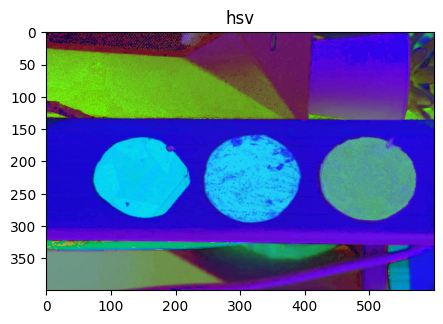

In [8]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(5,5))
plt.imshow(hsv, cmap='gray', vmin=0, vmax=255)
plt.title("hsv")
#plt.axis('off')
plt.show()

## 面積值設定

In [9]:
#Resize的參數設定
MIN_RADIUS = 45
MIN_AREA   = 3.14159*MIN_RADIUS*MIN_RADIUS
MAX_RADIUS = 80
MAX_AREA   = 3.14159*MAX_RADIUS*MAX_RADIUS

#原圖的參數設定
"""
MIN_RADIUS = 450
MIN_AREA   = 3.14159*MIN_RADIUS*MIN_RADIUS
MAX_RADIUS = 800
MAX_AREA   = 3.14159*MAX_RADIUS*MAX_RADIUS
"""

'\nMIN_RADIUS = 450\nMIN_AREA   = 3.14159*MIN_RADIUS*MIN_RADIUS\nMAX_RADIUS = 800\nMAX_AREA   = 3.14159*MAX_RADIUS*MAX_RADIUS\n'

### 題外話:
也可以透過減掉255來反轉顏色

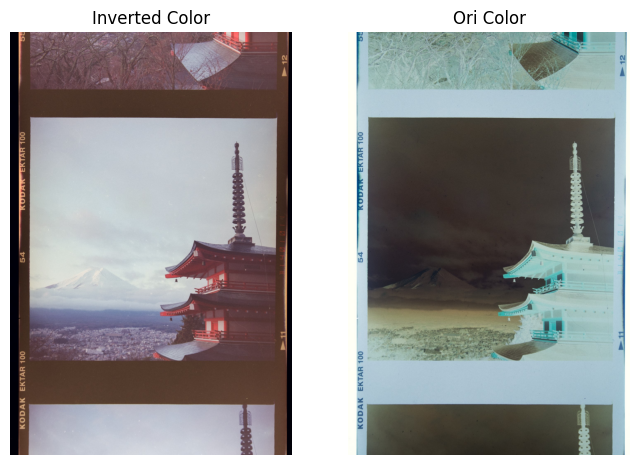

In [11]:
film_path = r"C:\0725\Advance_DIP\bgr_film.jpg"  # 改成你的檔案路徑
film = cv2.imread(film_path)

# BGR 轉為 RGB
film_r = cv2.cvtColor(film, cv2.COLOR_BGR2RGB)

# 反轉顏色
film_inv = 255 - film_r  

# 顯示反轉後的圖片
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.imshow(film_inv, vmin=0, vmax=255)
plt.axis('off')
plt.title("Inverted Color")
plt.subplot(1,2,2)
plt.imshow(film_r, vmin=0, vmax=255)
plt.axis('off')
plt.title("Ori Color")
plt.show()


## 建立紅／綠／黃三色遮罩
分別建立三種色罩方便過濾顏色

In [12]:
masks = {
    'Red': cv2.bitwise_or(
        cv2.inRange(hsv, (0,100,100),   (10,255,255)),
        cv2.inRange(hsv, (160,100,100), (180,255,255))
    ),
    'Green':  cv2.inRange(hsv, (40,50,20),  (80,255,255)),
    'Yellow': cv2.inRange(hsv, (20,100,100),(30,255,255)),
}

## 去雜訊並找輪廓
1.通過膨脹、侵蝕技巧來恢復影像形狀  
2.用cv2.findContours找到圖形邊緣  
3.用cv2.contourArea計算邊緣面積框出的面積並與設定值比較與過濾



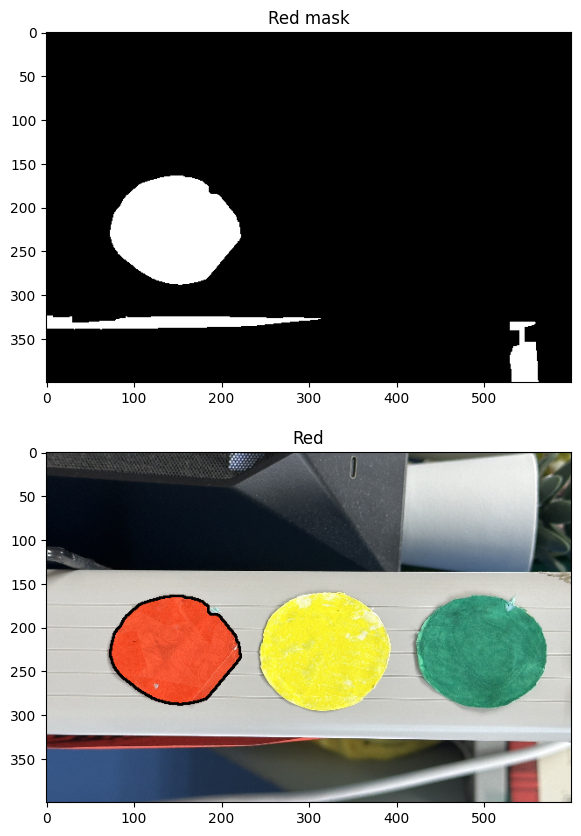

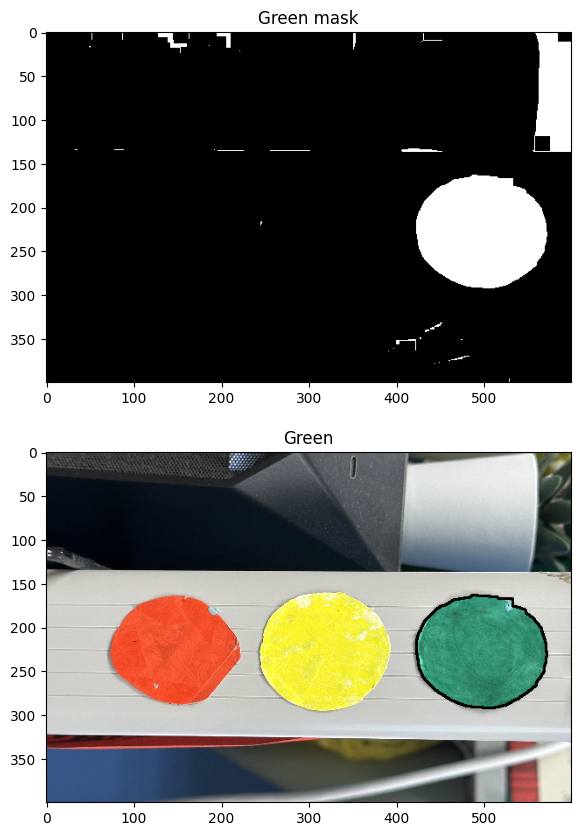

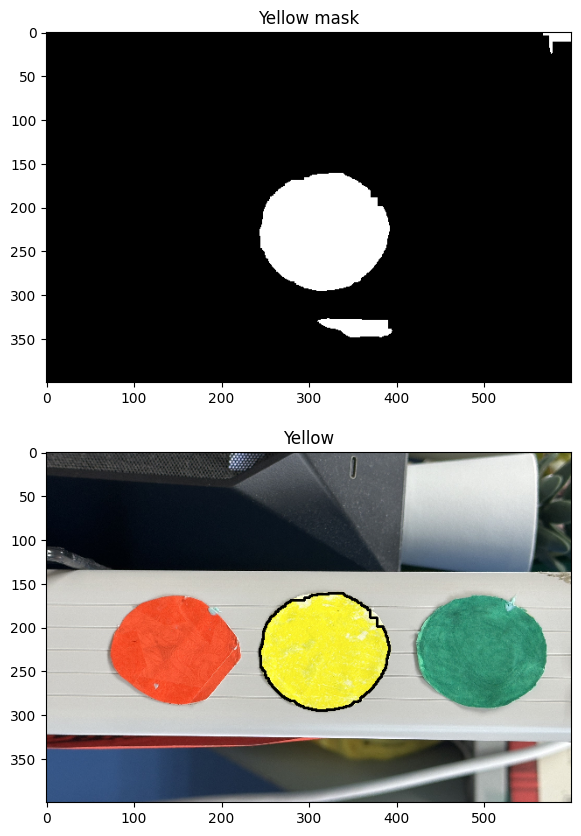

In [13]:
detections = []                                      # 建立空列表，用來儲存後續檢測到的物體資訊
kernel = np.ones((17,17), np.uint8)                  # 定義一個遮罩，用於閉、開運算               

for color, mask in masks.items():
    # 閉運算
    clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)      
    #clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # 找輪廓
    cnts, _ = cv2.findContours(
        clean,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # 複製影像以繪製結果
    result_img = frame.copy()

    for cnt in cnts:
        area = cv2.contourArea(cnt)
        if area < MIN_AREA or area >MAX_AREA:
            continue
        
        # 繪製輪廓
        cv2.drawContours(result_img, [cnt], -1, (0, 0, 0), 2)  # 輪廓

        # 找圓心半徑
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)

        # 儲存檢測資訊
        detections.append({
            'color':  color,
            'center': center,
            'radius': radius
        })
    rgb_result = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # 顯示結果與遮罩
    plt.figure(figsize=(8,10))
    plt.subplot(2,1,1)
    plt.imshow(clean, cmap='gray')
    plt.title(f"{color} mask")
    plt.subplot(2,1,2)
    plt.imshow(rgb_result)
    plt.title(f"{color}")
    plt.show()

## 排序與繪圖

In [14]:
detections.sort(key=lambda d: d['center'][0])  

# 標註 Left/Center/Right 並畫在影像上
order_str = []                                # 初始化空列表，用來儲存後續要印出的顏色(位置)字串
for i, det in enumerate(detections):          # 用 enumerate 同時取得索引 i 與檢測結果 det
    cx, cy = det['center']                    # 解包圓心座標：cx 為 X，cy 為 Y
    r      = det['radius']                    # 取出圓半徑
    col    = det['color']                     # 取出顏色標籤

    # 動態決定標籤
    if len(detections) == 1:                  # 只有一個物體
        pos = 'Center'                        
    elif len(detections) == 2:                # 有兩個物體
        pos = 'Left' if i == 0 else 'Right'   # 第一個標 Left，第二個標 Right
    else:                                     # 三個或以上
        if i == 0:                            # 最左側
            pos = 'Left'
        elif i == len(detections) - 1:        # 最右側
            pos = 'Right'
        else:                                 # 中間
            pos = 'Center'

    # 畫圓與文字
    cv2.circle(frame, (cx, cy), r, (0,0,0), 2)  
    # 以 (cx,cy) 為圓心、r 為半徑，線寬 5
    cv2.putText(
        frame, pos,                          # 標註文字內容：Left/Center/Right
        (cx,cy),                             # 文字位置設定在圓心上
        cv2.FONT_HERSHEY_SIMPLEX,            # 字型
        0.5,                                 # 字體縮放比例
        (0,0,0),                             # 文字顏色(黑)
        2                                    # 文字線寬
    )
    order_str.append(f"{col}({pos})")        # 將「顏色(位置)」的字串加入 order_str 列表

# 列印排序結果
if order_str:                                # 如果有偵測到任何物體
    print("物體相對位置：", " < ".join(order_str))  
    # 將 order_str 用 " < " 串接，並印出
else:                                        # 如果完全沒有偵測到物體
    print("未偵測到符合條件的物體。")      

物體相對位置： Red(Left) < Yellow(Center) < Green(Right)


## 秀圖

Text(0.5, 1.0, 'final')

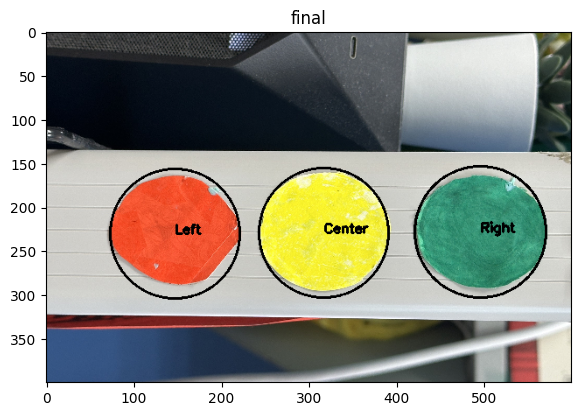

In [15]:
final = frame.copy()
final_frame = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.imshow(final_frame, cmap='gray')
plt.title("final")

## 儲存到指定位置

In [16]:
# 指定資料夾與檔名
output_dir  = r'C:\Users\User\Desktop\advance_dip\result'    # 資料夾
output_file = 'adv_result.jpg'                            # 副檔名
# 確保資料夾存在，否則自動建立
os.makedirs(output_dir, exist_ok=True)
# 取得完整路徑
output_path = os.path.join(output_dir, output_file)

# 儲存影像並檢查是否成功
if cv2.imwrite(output_path, frame):
    print(f"已儲存標註後影像到：{output_path}")
else:
    print("儲存失敗，請檢查路徑與權限")

cv2.waitKey(0)
cv2.destroyAllWindows()

已儲存標註後影像到：C:\Users\User\Desktop\advance_dip\result\adv_result.jpg
